# **HW2: KNN and Linear Regression**

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("denkuznetz/taxi-price-prediction")
taxi_data = pd.read_csv(f"{path}/taxi_trip_pricing.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


<Axes: >

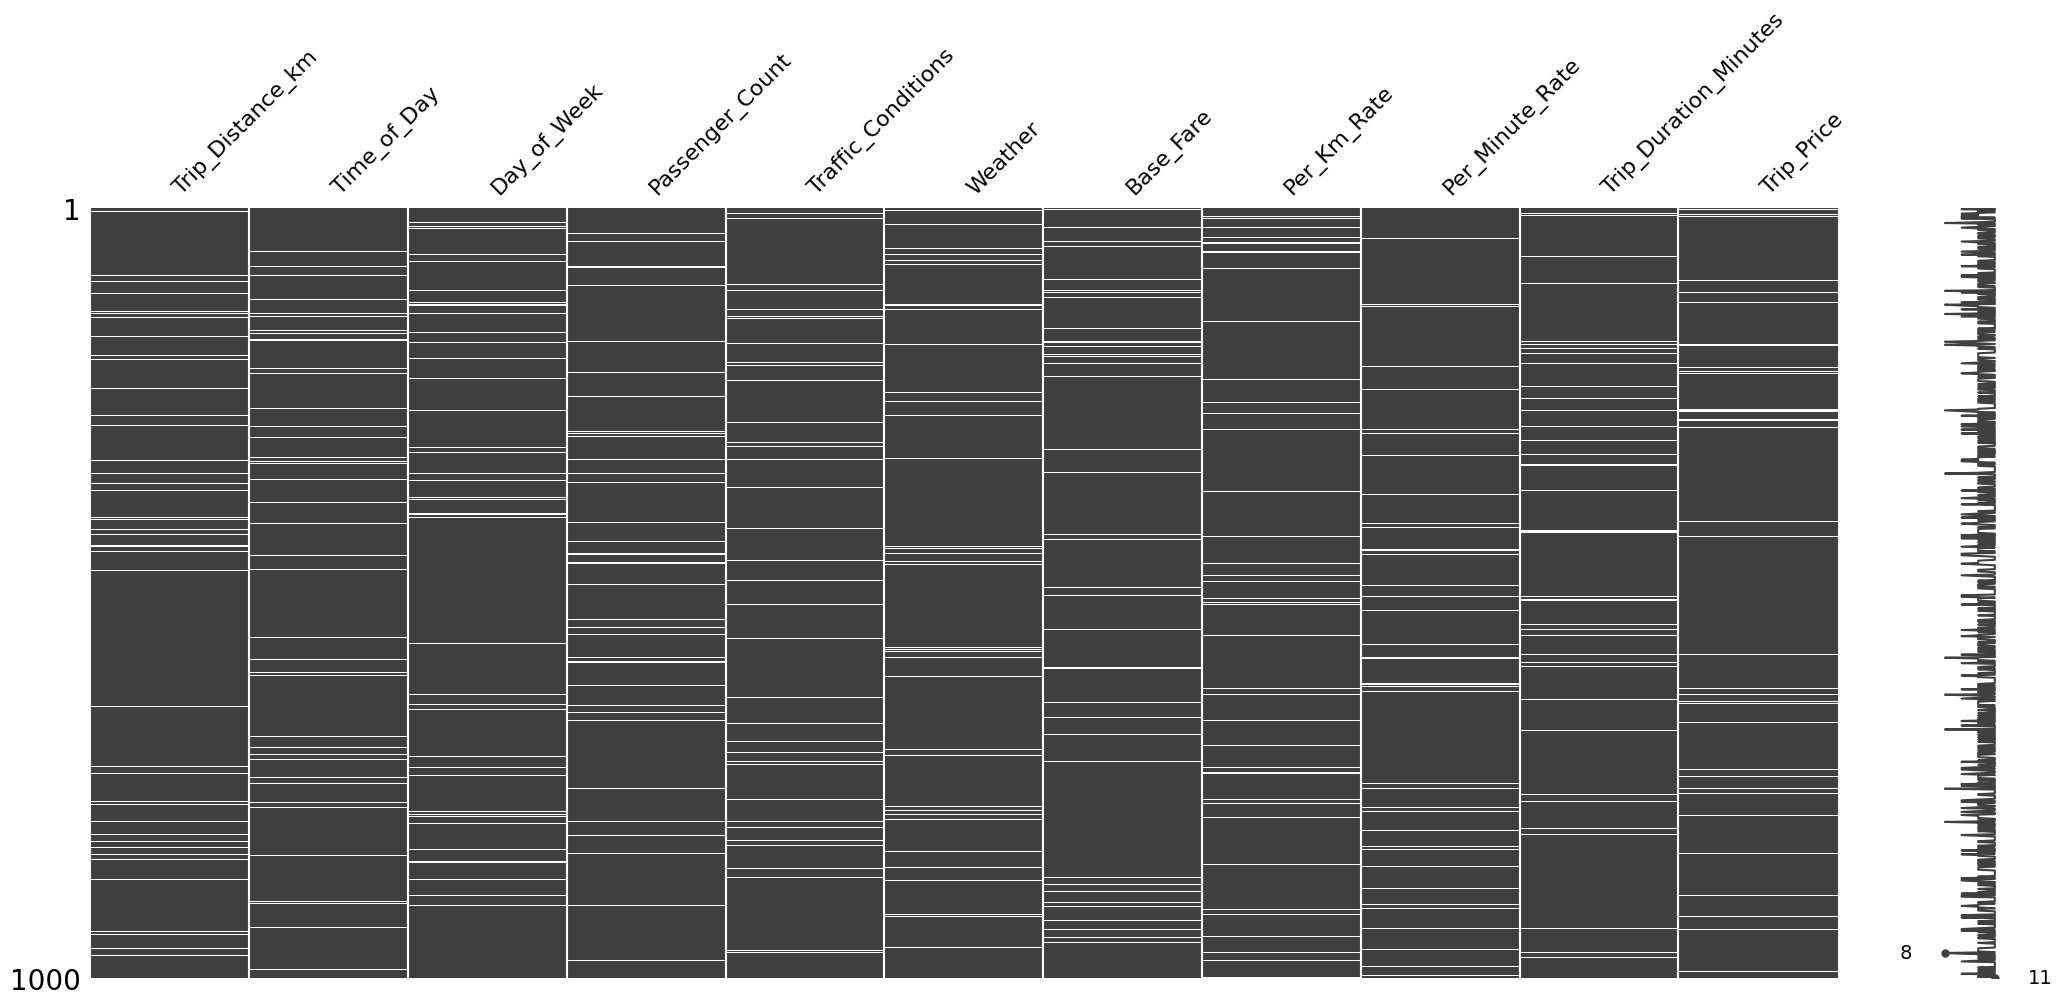

In [ ]:
taxi_data.info()
msno.matrix(taxi_data)

The dataset contains approximately 50 missing values across different features. Handling these NaNs appropriately is crucial to maintaining data quality.
I handled the missing values in the dataset by filling numerical features, such as **Trip Distance**, **Passenger Count**, and **Base Fare**, with the **median** value to preserve the distribution of the data. For categorical features like **Day_of_Week**, **Time_of_Day**, **Weather**, and **Traffic_Conditions**, I filled the missing values with the **mode** to maintain the common patterns in the data.

In [ ]:
# filling nan values֊ից առաջ պետք է split անել train֊ի և test֊ի։ Քանի որ իրական կյանքում
# test set֊ը մենք չենք տեսնում և նրա mode֊ը կամ median֊ը չենք կարող հաշվել, ուստի պետք է
# օգտագործել train֊ի տվյալները
taxi_data['Trip_Distance_km'] = taxi_data['Trip_Distance_km'].fillna(taxi_data['Trip_Distance_km'].median())
taxi_data['Passenger_Count'] = taxi_data['Passenger_Count'].fillna(taxi_data['Passenger_Count'].median())
taxi_data['Base_Fare'] = taxi_data['Base_Fare'].fillna(taxi_data['Base_Fare'].median())
taxi_data['Per_Km_Rate'] = taxi_data['Per_Km_Rate'].fillna(taxi_data['Per_Km_Rate'].median())
taxi_data['Per_Minute_Rate'] = taxi_data['Per_Minute_Rate'].fillna(taxi_data['Per_Minute_Rate'].median())
taxi_data['Trip_Duration_Minutes'] = taxi_data['Trip_Duration_Minutes'].fillna(taxi_data['Trip_Duration_Minutes'].median())
taxi_data['Trip_Price'] = taxi_data['Trip_Price'].fillna(taxi_data['Trip_Price'].median())

In [ ]:
# filling nan values֊ից առաջ պետք է split անել train֊ի և test֊ի։ Քանի որ իրական կյանքում
# test set֊ը մենք չենք տեսնում և նրա mode֊ը կամ median֊ը չենք կարող հաշվել, ուստի պետք է
# օգտագործել train֊ի տվյալները
taxi_data['Day_of_Week'] = taxi_data['Day_of_Week'].fillna(taxi_data['Day_of_Week'].mode()[0])
taxi_data['Time_of_Day'] = taxi_data['Time_of_Day'].fillna(taxi_data['Time_of_Day'].mode()[0])
taxi_data['Weather'] = taxi_data['Weather'].fillna(taxi_data['Weather'].mode()[0])
taxi_data['Traffic_Conditions'] = taxi_data['Traffic_Conditions'].fillna(taxi_data['Traffic_Conditions'].mode()[0])
taxi_data

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,3.52,0.62,0.43,40.57,50.0745
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,Clear,3.48,0.51,0.15,116.81,36.4698
4,25.83,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
...,...,...,...,...,...,...,...,...,...,...,...
995,5.49,Afternoon,Weekend,4.0,Medium,Clear,2.39,0.62,0.49,58.39,34.4049
996,45.95,Night,Weekday,4.0,Medium,Clear,3.12,0.61,0.29,61.96,62.1295
997,7.70,Morning,Weekday,3.0,Low,Rain,2.08,1.78,0.29,54.18,33.1236
998,47.56,Morning,Weekday,1.0,Low,Clear,2.67,0.82,0.17,114.94,61.2090


In [ ]:
#taxi_data.describe()

In [ ]:
target_column = 'Trip_Price'

for feature in taxi_data.columns:
    if feature != target_column:
        plt.figure(figsize=(14, 12))
        sns.scatterplot(x=taxi_data[feature], y=taxi_data[target_column])
        plt.title(f"{feature} vs {target_column}")
        plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.scatterplot(x=taxi_data['Passenger_Count'], y=taxi_data['Trip_Price'])
# plt.title("Passenger Count vs Trip Price")
# plt.xlabel("Passenger Count")
# plt.ylabel("Trip Price")
# plt.show()

correlation = taxi_data['Passenger_Count'].corr(taxi_data['Trip_Price'])
print(f"Correlation between Passenger Count and Trip Price: {correlation}")

taxi_data = taxi_data.drop('Passenger_Count', axis=1)

Correlation between Passenger Count and Trip Price: -0.012468271002869725


The correlation between Passenger Count and Trip Price is very close to 0. This indicates that there is no linear relationship between the number of passengers and trip price.So I think it's good strategy to remove Passenger_Count feature.

In [ ]:
# կարող ես կորելյացիոն մատրիցա կազմել, որ հատ-հատ չհաշվես
import seaborn as sns
import matplotlib.pyplot as plt

correlation = taxi_data['Trip_Distance_km'].corr(taxi_data['Trip_Price'])
print(f"Correlation between Trip_Distance_km and Trip Price: {correlation}")

correlation = taxi_data['Trip_Duration_Minutes'].corr(taxi_data['Trip_Price'])
print(f"Correlation between Trip_Duration_Minutes and Trip Price: {correlation}")


The correlation results indicate the following:

* Trip Distance and Trip Price: The correlation of 0.85 is quite strong and positive, suggesting that as the Trip Distance increases, the Trip Price tends to increase as well. This is expected, as longer trips typically result in higher fares.

* Trip Duration and Trip Price: The correlation of 0.22 is relatively weak but positive, indicating that there is a mild relationship between Trip Duration and Trip Price. Longer trips, in terms of duration, might increase the price, but the relationship is not as strong as with Trip Distance.

In [ ]:
correlation = taxi_data['Per_Km_Rate'].corr(taxi_data['Per_Minute_Rate'])
print(f"Correlation between Per_Km_Rate and Per_Minute_Rate: {correlation}")

In [ ]:
num_df = taxi_data.select_dtypes(include=['float64', 'int64'])


correlation_matrix = num_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numerical Variables Only)')
plt.show()

In [ ]:
time_of_day_dummies = pd.get_dummies(taxi_data['Time_of_Day'], prefix='TDay')
taxi_data = pd.concat([taxi_data, time_of_day_dummies * 1], axis=1)

taxi_data = taxi_data.drop('Time_of_Day', axis=1)

traffic_conditions_dummies = pd.get_dummies(taxi_data['Traffic_Conditions'], prefix='TrafficCnd')
taxi_data = pd.concat([taxi_data, traffic_conditions_dummies * 1], axis=1)

taxi_data = taxi_data.drop('Traffic_Conditions', axis=1)

In [ ]:
#print(taxi_data['Day_of_Week'].value_counts())
#print(taxi_data['Weather'].value_counts())

In [ ]:
taxi_data['Day_of_Week'] = taxi_data['Day_of_Week'].map({'Weekday': 0, 'Weekend': 1})

weather_dummies = pd.get_dummies(taxi_data['Weather'], prefix='Weather')
taxi_data = pd.concat([taxi_data, weather_dummies * 1], axis=1)

taxi_data = taxi_data.drop('Weather', axis=1)

In [ ]:
taxi_data['Dist_x_PerMinute'] = taxi_data['Trip_Distance_km'] * taxi_data['Per_Minute_Rate']
taxi_data['Trip_Distance_sq'] = taxi_data['Trip_Distance_km'] ** 2
taxi_data['Per_Minute_Rate_sq'] = taxi_data['Per_Minute_Rate'] ** 2


In [ ]:
taxi_data['Log_Trip_Dist'] = np.log(taxi_data['Trip_Distance_km'] + 1)
taxi_data['Log_Per_Min_Rate'] = np.log(taxi_data['Per_Minute_Rate'] + 1)


In [ ]:
taxi_data

In [ ]:
cts_features = [
    'Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate',
    'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price', 'Dist_x_PerMinute', 'Trip_Distance_sq', 'Per_Minute_Rate_sq'
]

scaler = StandardScaler()

# Կոպիտ սխալ ես արել scaling֊ի մեջ, test set-ը պետք է scale լինի նույն պարամետրերով ինչ train֊ը
taxi_data[cts_features] = scaler.fit_transform(taxi_data[cts_features])

**Splitting dataset into training and testing sets. Adding bias term**


In [ ]:
X = taxi_data.drop(columns=['Trip_Price'])
y = taxi_data['Trip_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.insert(0, 'Bias', 1)
X_test.insert(0, 'Bias', 1)


# **Sklearn Linear Regression and KNN Reggression**

In [ ]:
# մի բջջի համար այսքան կոդը շատէ, մասնատիր մասերի


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train_lr = lin_reg.predict(X_train)
y_pred_test_lr = lin_reg.predict(X_test)

sk_mse_train_lr = mean_squared_error(y_train, y_pred_train_lr)
sk_mae_train_lr = mean_absolute_error(y_train, y_pred_train_lr)
sk_r2_train_lr = r2_score(y_train, y_pred_train_lr)

sk_mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
sk_mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
sk_r2_test_lr = r2_score(y_test, y_pred_test_lr)

print("Linear Regression Results:")
print("Train - Mean Squared Error:", sk_mse_train_lr)
print("Train - Mean Absolute Error:", sk_mae_train_lr)
print("Train - R^2 Score:", sk_r2_train_lr)
print("Test - Mean Squared Error:", sk_mse_test_lr)
print("Test - Mean Absolute Error:", sk_mae_test_lr)
print("Test - R^2 Score:", sk_r2_test_lr)

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_train_ridge = ridge_reg.predict(X_train)
y_pred_test_ridge = ridge_reg.predict(X_test)

sk_mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
sk_mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
sk_r2_train_ridge = r2_score(y_train, y_pred_train_ridge)

sk_mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
sk_mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
sk_r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print("\nRidge Regression Results:")
print("Train - Mean Squared Error:", sk_mse_train_ridge)
print("Train - Mean Absolute Error:", sk_mae_train_ridge)
print("Train - R^2 Score:", sk_r2_train_ridge)
print("Test - Mean Squared Error:", sk_mse_test_ridge)
print("Test - Mean Absolute Error:", sk_mae_test_ridge)
print("Test - R^2 Score:", sk_r2_test_ridge)

param_grid_lasso = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')

grid_search_lasso.fit(X_train, y_train)

best_alpha_lasso = grid_search_lasso.best_params_['alpha']
print("\nBest Alpha for Lasso Regression:", best_alpha_lasso)

lasso_reg = Lasso(alpha=best_alpha_lasso)
lasso_reg.fit(X_train, y_train)

y_pred_train_lasso = lasso_reg.predict(X_train)
y_pred_test_lasso = lasso_reg.predict(X_test)

sk_mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
sk_mae_train_lasso = mean_absolute_error(y_train, y_pred_train_lasso)
sk_r2_train_lasso = r2_score(y_train, y_pred_train_lasso)

sk_mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
sk_mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
sk_r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

print("\nLasso Regression Results (Best Alpha =", best_alpha_lasso, ")")
print("Train - Mean Squared Error:", sk_mse_train_lasso)
print("Train - Mean Absolute Error:", sk_mae_train_lasso)
print("Train - R^2 Score:", sk_r2_train_lasso)
print("Test - Mean Squared Error:", sk_mse_test_lasso)
print("Test - Mean Absolute Error:", sk_mae_test_lasso)
print("Test - R^2 Score:", sk_r2_test_lasso)


param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17]}  # նաև distance-ի տարբերակները այստեղ ավելացրու
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print("\nBest K from GridSearchCV:", best_k)

knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred_train_knn = knn.predict(X_train)
y_pred_test_knn = knn.predict(X_test)

sk_mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
sk_mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
sk_r2_train_knn = r2_score(y_train, y_pred_train_knn)

sk_mse_test_knn = mean_squared_error(y_test, y_pred_test_knn)
sk_mae_test_knn = mean_absolute_error(y_test, y_pred_test_knn)
sk_r2_test_knn = r2_score(y_test, y_pred_test_knn)

print("\nKNN Regression Results (Best K =", best_k, ")")
print("Train - Mean Squared Error:", sk_mse_train_knn)
print("Train - Mean Absolute Error:", sk_mae_train_knn)
print("Train - R^2 Score:", sk_r2_train_knn)
print("Test - Mean Squared Error:", sk_mse_test_knn)
print("Test - Mean Absolute Error:", sk_mae_test_knn)
print("Test - R^2 Score:", sk_r2_test_knn)


Linear Regression Results:
Train - Mean Squared Error: 0.10446360477348796
Train - Mean Absolute Error: 0.20387946110733388
Train - R^2 Score: 0.9063536995897744
Test - Mean Squared Error: 0.06963355637490078
Test - Mean Absolute Error: 0.1824196247740921
Test - R^2 Score: 0.8693976203238618

Ridge Regression Results:
Train - Mean Squared Error: 0.10457166763249877
Train - Mean Absolute Error: 0.203603170330831
Train - R^2 Score: 0.9062568267412827
Test - Mean Squared Error: 0.06983448328843336
Test - Mean Absolute Error: 0.18268979044005804
Test - R^2 Score: 0.8690207684953115

Best Alpha for Lasso Regression: 0.01

Lasso Regression Results (Best Alpha = 0.01 )
Train - Mean Squared Error: 0.10782908039677232
Train - Mean Absolute Error: 0.2086567794117633
Train - R^2 Score: 0.9033367221273868
Test - Mean Squared Error: 0.07212645251948614
Test - Mean Absolute Error: 0.18754260766512754
Test - R^2 Score: 0.8647220273236216

Best K from GridSearchCV: 5

KNN Regression Results (Best K = 

# **Linear Regression implementation (Gradient Descent)**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# իմպլեմենտացիան ճիշտ է, բայց ավելի կառուցվածքային կլինի, որ առանձին class սահմանես և այս բոլոր ֆունկցիաները հավաքես class-ի մեջ

def generate_polynomial_features(X, degree):
    X_poly = X.copy()
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, np.power(X, d)))
    return X_poly

def gradient_descent(X, y, alpha=0.001, eps=1e-6, iter=10000):
    m, n = X.shape
    w = np.zeros(n)

    # կարելի է numpy-ով անել
    for i in range(iter):
        y_pred = X @ w
        J = np.sum((y_pred - y)**2) / (2*m)

        gradient = (X.T @ (y_pred - y)) / m
        if np.linalg.norm(gradient) < eps:
            break

        w -= alpha * gradient
    return w

degree = 3
X_train_poly = generate_polynomial_features(X_train, degree)
X_test_poly = generate_polynomial_features(X_test, degree)

weights = gradient_descent(X_train_poly, y_train, alpha=0.0001)

y_pred_train_grad = X_train_poly @ weights
y_pred_test_grad = X_test_poly @ weights

mse_train_grad = mean_squared_error(y_train, y_pred_train_grad)
mae_train_grad = mean_absolute_error(y_train, y_pred_train_grad)
r2_train_grad = r2_score(y_train, y_pred_train_grad)

mse_test_grad = mean_squared_error(y_test, y_pred_test_grad)
mae_test_grad = mean_absolute_error(y_test, y_pred_test_grad)
r2_test_grad = r2_score(y_test, y_pred_test_grad)

print("Polynomial Regression (Gradient Descent) Results:")
print("Train MSE:", mse_train_grad)
print("Test MSE:", mse_test_grad)
print("Train MAE:", mae_train_grad)
print("Test MAE:", mae_test_grad)
print("Train R^2 Score:", r2_train_grad)
print("Test R^2 Score:", r2_test_grad)


Polynomial Regression (Gradient Descent) Results:
Train MSE: 0.10555998890183727
Test MSE: 0.07195226850293103
Train MAE: 0.22366216957958038
Test MAE: 0.20254179381225199
Train R^2 Score: 0.9053708470673957
Test R^2 Score: 0.8650487210650868


# **KNN Regression implementation**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# իմպլեմենտացիան ճիշտ է, բայց ավելի կառուցվածքային կլինի, որ առանձին class սահմանես և այս բոլոր ֆունկցիաները հավաքես class-ի մեջ


def euclidean_dist(X_train, x_test):
    return np.sqrt(np.sum(np.square(np.array(X_train) - np.array(x_test)), axis=1))

# manhattan-ի ժամանակ արմատ հանել պետք չէ
def manhattan_dist(X_train, x_test):
  return np.sqrt(np.sum(np.abs(np.array(X_train) - np.array(x_test)), axis=1))

def knn_regression(X_train, y_train, X_test, k=9):
    y_pred = []
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    for x in X_test:
        dist = euclidean_dist(X_train, x)
        knn_indices = np.argsort(dist)[:k]
        knn_vals = y_train[knn_indices]
        y_pred.append(np.mean(knn_vals))
    return np.array(y_pred)

y_pred_train_knn = knn_regression(X_train, y_train, X_train, k=9)
y_pred_test_knn = knn_regression(X_train, y_train, X_test, k=9)

mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
r2_train_knn = r2_score(y_train, y_pred_train_knn)

mse_test_knn = mean_squared_error(y_test, y_pred_test_knn)
mae_test_knn = mean_absolute_error(y_test, y_pred_test_knn)
r2_test_knn = r2_score(y_test, y_pred_test_knn)

print("KNN Regression Results:")
print("Train MSE:", mse_train_knn)
print("Test MSE:", mse_test_knn)
print("Train MAE:", mae_train_knn)
print("Test MAE:", mae_test_knn)
print("Train R^2 Score:", r2_train_knn)
print("Test R^2 Score:", r2_test_knn)


KNN Regression Results:
Train MSE: 0.08962277196815702
Test MSE: 0.06837098377920649
Train MAE: 0.21122894694852867
Test MAE: 0.20091398781631895
Train R^2 Score: 0.9196577502229062
Test R^2 Score: 0.8717656594431591


In [ ]:
metrics = {
    'Model': ['Sklearn Linear Regression', 'Sklearn Ridge Regression', 'Sklearn Lasso Regression', 'KNN Regression (Grid Search)', 'Custom Linear Regression', 'Custom KNN'],
    'Train MSE': [sk_mse_train_lr, sk_mse_train_ridge, sk_mse_train_lasso, sk_mse_train_knn, mse_train_grad, mse_train_knn],
    'Test MSE': [sk_mse_test_lr, sk_mse_test_ridge, sk_mse_test_lasso, sk_mse_test_knn, mse_test_grad, mse_test_knn],
    'Train MAE': [sk_mae_train_lr, sk_mae_train_ridge, sk_mae_train_lasso, sk_mae_train_knn, mae_train_grad, mae_train_knn],
    'Test MAE': [sk_mae_test_lr, sk_mae_test_ridge, sk_mae_test_lasso, sk_mae_test_knn, mae_test_grad, mae_test_knn],
    'Train R^2': [sk_r2_train_lr, sk_r2_train_ridge, sk_r2_train_lasso, sk_r2_train_knn, r2_train_grad, r2_train_knn],
    'Test R^2': [sk_r2_test_lr, sk_r2_test_ridge, sk_r2_test_lasso, sk_r2_test_knn, r2_test_grad, r2_test_knn]
}

df_metrics = pd.DataFrame(metrics)
df_metrics


,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2
0,Sklearn Linear Regression,0.104464,0.069634,0.203879,0.182420,0.906354,0.869398
1,Sklearn Ridge Regression,0.104572,0.069834,0.203603,0.182690,0.906257,0.869021
2,Sklearn Lasso Regression,0.107829,0.072126,0.208657,0.187543,0.903337,0.864722
3,KNN Regression (Grid Search),0.086460,0.068078,0.203775,0.198485,0.922493,0.872316
4,Custom Linear Regression,0.105560,0.071952,0.223662,0.202542,0.905371,0.865049
5,Custom KNN,0.089623,0.068371,0.211229,0.200914,0.919658,0.871766
